In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pypsa
import pyomo.environ as pyo
import pyomo.version
import shapely
import tqdm
print('pandas', pd.__version__)
print('geopandas', gpd.__version__)
print('xarray', xr.__version__)
print('pypsa', pypsa.__version__)
print('pyomo', getattr(pyo, '__version__', pyomo.version.version))
print('shapely', shapely.__version__)
print('tqdm', tqdm.__version__)

pandas 2.3.3
geopandas 1.1.1
xarray 2025.12.0
pypsa 1.0.5
pyomo 6.9.5
shapely 2.1.2
tqdm 4.67.1


In [ ]:
from importlib import reload
import sys
from pathlib import Path

repo_root = Path().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from model import main as plant_main

plant_main = reload(plant_main)

plant_dir = repo_root / "basic_ammonia_plant"
net = plant_main.generate_network(24, plant_dir, aggregation_count=1, time_step=1.0)
print(f"Network components: {len(net.links)} links, {len(net.generators)} generators, {len(net.stores)} stores")

INFO:pypsa.network.io:New version 1.0.6 available! (Current: 1.0.5)
INFO:pypsa.network.io:Imported network 'Basic Ammonia Plant v1' has buses, generators, links, loads, stores


Tech config entries: 13 from tech_config.yaml
Network components: 8 links, 5 generators, 4 stores)


In [3]:
from importlib import reload
from pathlib import Path
import logging
import numbers
import os

from model import auxiliary as aux
from model import main as plant_main

os.environ.setdefault("GREEN_LORY_SOLVER_LOG", "0")

aux = reload(aux)
plant_main = reload(plant_main)

logging.getLogger("pypsa").setLevel(logging.WARNING)
logging.getLogger("pypsa.optimization").setLevel(logging.ERROR)
logging.getLogger("pypsa.optimization.constraints").setLevel(logging.ERROR)
logging.getLogger("linopy").setLevel(logging.WARNING)
logging.getLogger("linopy.io").setLevel(logging.WARNING)
logging.getLogger("gurobipy").setLevel(logging.WARNING)

repo_root = Path().resolve().parent
weather_file = repo_root / "data" / "single_site_weather_data.csv"
weather_data = aux.get_weather_data(file_name=str(weather_file), aggregation_count=1)
snap_len = len(weather_data)
solver = "gurobi"
results = plant_main.main(file_name=str(weather_file), multi_site=True, aggregation_count=1, time_step=1.0)

print("Single-location run summary:")
print(f"  Weather file: {weather_file.relative_to(repo_root)}")
print(f"  Snapshots: {snap_len} (aggregation_count=1)")
print(f"  Solver: {solver}")
lcoa = results.get("lcoa_usd_per_t")
if lcoa is not None:
    print(f"  LCOA: {lcoa:.2f} USD/t")

print("Key outputs (MW for capacities, MWh for energy stores):")
for name, value in results.items():
    if name in {"lcoa_usd_per_t", "annual_ammonia_demand_mwh", "annual_ammonia_production_t", "total_cost_usd_per_year"} or name.startswith("cost_share_") or name.startswith("lcoa_component_") or name.startswith("interest_rate_") or name.endswith("_share_pct"):
        continue
    if isinstance(value, numbers.Real):
        formatted_value = f"{value:,.2f}"
    else:
        formatted_value = value
    unit = "MWh" if name in {"ammonia", "compressed_hydrogen_store", "battery", "accumulated_penalty"} else "MW"
    if name == "hydrogen_storage_capacity":
        unit = "t"
    print(f"  {name}: {formatted_value} {unit}")

Aggregating weather data...
Aggregating weather data...


Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 252.22it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-10


Read LP format model from file /private/var/folders/6b/x50zyszd41z391jpwblh3ryh0000gn/T/linopy-problem-1417tj5h.lp
Reading time = 0.46 seconds
obj: 429267 rows, 183975 columns, 878482 nonzeros
Single-location run summary:
  Weather file: data/single_site_weather_data.csv
  Snapshots: 8760 (aggregation_count=1)
  Solver: gurobi
  LCOA: 742.94 USD/t
Key outputs (MW for capacities, MWh for energy stores):
  wind: 6,617.97 MW
  solar: 36,277.05 MW
  solar_tracking: 0.00 MW
  grid: 0.00 MW
  ramp_dummy: 0.00 MW
  electrolysis: 18,482.53 MW
  hydrogen_compression: 8,627.71 MW
  hydrogen_from_storage: 10,619.14 MW
  ammonia_synthesis: 8,684.80 MW
  battery_interface_in: 9.59 MW
  battery_interface_out: 9.49 MW
  hydrogen_fuel_cell: 415.30 MW
  penalty_link: 0.00 MW
  ammonia: 2,806,822.87 MWh
  compressed_hydrogen_store: 83,175.08 MWh
  battery: 18.99 MWh
  accumulated_penalty: 0.00 MWh
  hydrogen_storage_capacity: 2,111.04 t


### Single-case diagnostic run
Re-run the single-location optimisation while keeping the solved `pypsa.Network` object in memory so we can inspect time-series behaviour before scaling to multi-area batches.

In [4]:
import matplotlib.pyplot as plt

# Build a fresh network with the full weather series length
single_case_net = plant_main.generate_network(
    len(weather_data),
    plant_dir,
    aggregation_count=1,
    time_step=1.0,
)

renewables = set(single_case_net.generators.index)
for column in weather_data.columns:
    if column in renewables:
        single_case_net.generators_t.p_max_pu[column] = weather_data[column].values

status, condition = single_case_net.optimize(
    solver_name=solver,
    extra_functionality=aux.linopy_constraints,
)
if status != "ok":
    raise RuntimeError(f"Diagnostic optimisation failed: {status} ({condition})")

diagnostic_results = aux.get_results_dict_for_multi_site(
    single_case_net,
    aggregation_count=1,
    time_step=1.0,
)
print(f"Diagnostic LCOA: {diagnostic_results['lcoa_usd_per_t']:.2f} USD/t")

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 257.13it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2026-12-10


Read LP format model from file /private/var/folders/6b/x50zyszd41z391jpwblh3ryh0000gn/T/linopy-problem-4bnaygt5.lp
Reading time = 0.46 seconds
obj: 429267 rows, 183975 columns, 878482 nonzeros
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 24.6.0 24G231)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 429267 rows, 183975 columns and 878482 nonzeros (Min)
Model fingerprint: 0x776f4dcb
Model has 35053 linear objective coefficients
Coefficient statistics:
  Matrix range     [1e-04, 7e+00]
  Objective range  [1e-04, 1e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+03, 1e+07]
Presolve removed 251005 rows and 84531 columns
Presolve time: 0.31s
Presolved: 178262 rows, 99444 columns, 592304 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.10s

Barrier statistics:
 Dense cols : 12
 AA' NZ     : 1.154e+06
 F

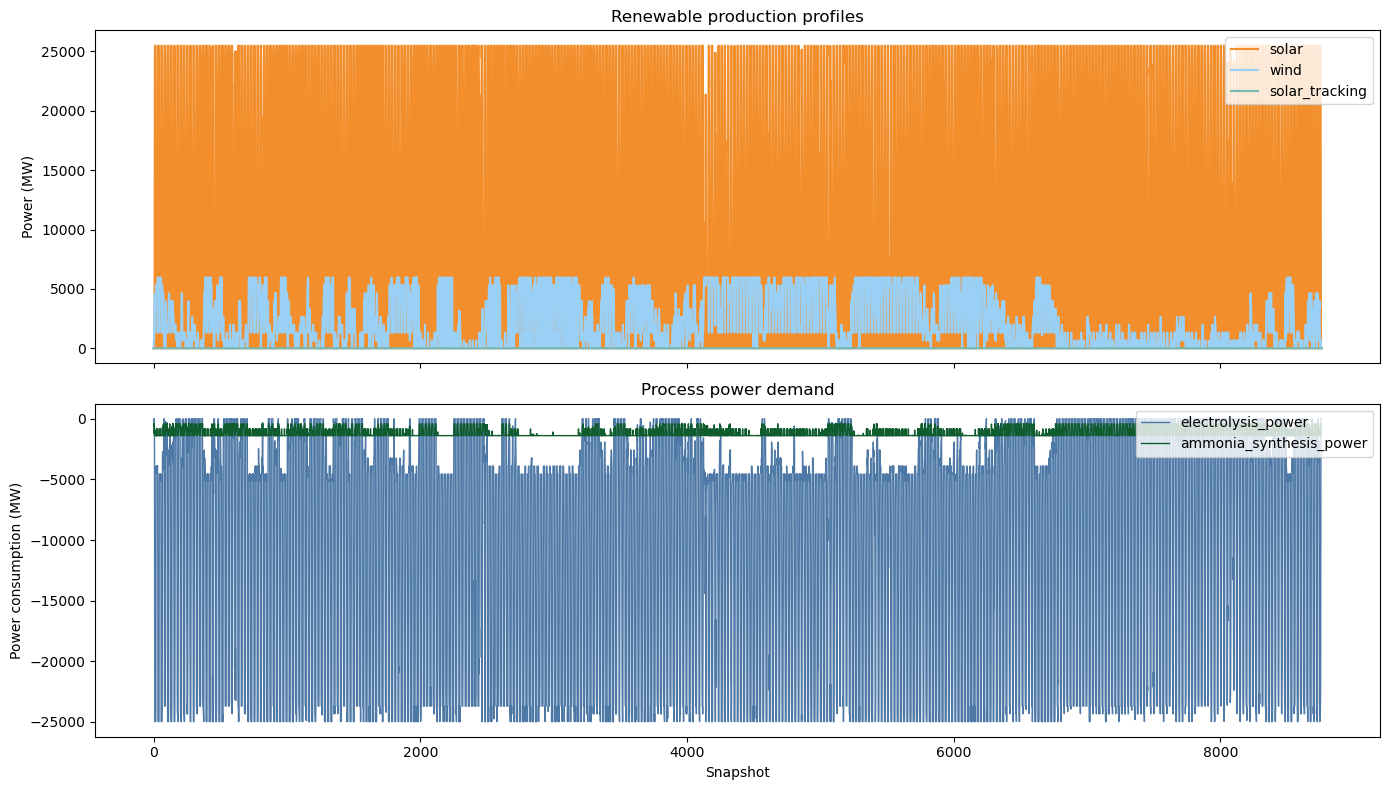

In [5]:
timeline_df = pd.DataFrame(index=single_case_net.snapshots)

for gen_name in ("wind", "solar", "solar_tracking"):
    if gen_name in single_case_net.generators.index:
        timeline_df[gen_name] = single_case_net.generators_t.p[gen_name]

if "electrolysis" in single_case_net.links_t.p0.columns:
    timeline_df["electrolysis_power"] = -single_case_net.links_t.p0["electrolysis"]
if "ammonia_synthesis" in single_case_net.links_t.p0.columns:
    timeline_df["ammonia_synthesis_power"] = -single_case_net.links_t.p0["ammonia_synthesis"]

palette = {
    "solar": "#f28e2b",
    "wind": "#9ad0f5",
    "solar_tracking": "#76b7b2",
    "electrolysis_power": "#4e79a7",
    "ammonia_synthesis_power": "#0f5c2f",
}

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
gen_cols = [c for c in ("wind", "solar", "solar_tracking") if c in timeline_df]
if gen_cols:
    ordered_gen_cols = sorted(gen_cols, key=lambda c: timeline_df[c].abs().mean(), reverse=True)
    colors = [palette.get(col, None) for col in ordered_gen_cols]
    timeline_df[ordered_gen_cols].plot(ax=axes[0], color=colors)
    axes[0].set_ylabel("Power (MW)")
    axes[0].set_title("Renewable production profiles")
    axes[0].legend(loc="upper right")
else:
    axes[0].set_visible(False)

consumption_cols = [c for c in ("electrolysis_power", "ammonia_synthesis_power") if c in timeline_df]
if consumption_cols:
    colors = [palette.get(col, None) for col in consumption_cols]
    timeline_df[consumption_cols].plot(ax=axes[1], linestyle="-", linewidth=1.0, color=colors)
    axes[1].set_ylabel("Power consumption (MW)")
    axes[1].set_title("Process power demand")
    axes[1].legend(loc="upper right")
axes[-1].set_xlabel("Snapshot")
plt.tight_layout()

#### Ammonia ramp-rate check
Confirm the solved dispatch respects the ±0.4 per-unit constraints encoded in `basic_ammonia_plant/links.csv`.

In [6]:
ammonia_series = -single_case_net.links_t.p0["ammonia_synthesis"]
installed_capacity = single_case_net.links.loc["ammonia_synthesis", "p_nom_opt"]
ramp_limit = single_case_net.links.loc["ammonia_synthesis", "ramp_limit_up"]
max_allowed_delta = ramp_limit * installed_capacity
observed_delta = ammonia_series.diff().abs().max()
print(f"Installed ammonia capacity: {installed_capacity:,.2f} MW")
print(f"Ramp limit (per snapshot): {ramp_limit:.2f} pu -> {max_allowed_delta:,.2f} MW")
print(f"Observed max change: {observed_delta:,.2f} MW")
print("Constraint respected?", observed_delta <= max_allowed_delta + 1e-6)

Installed ammonia capacity: 1,389.57 MW
Ramp limit (per snapshot): 0.40 pu -> 555.83 MW
Observed max change: 555.83 MW
Constraint respected? True


In [7]:
penalty_energy = single_case_net.stores_t.e["accumulated_penalty"]
print("Max accumulated_penalty energy (MWh):", penalty_energy.max())
print("Min accumulated_penalty energy (MWh):", penalty_energy.min())

Max accumulated_penalty energy (MWh): 0.0
Min accumulated_penalty energy (MWh): 0.0


### NetCDF ingestion sanity checks
Recreate the weather frame from the NetCDF stacks for a known site and confirm those values are exactly what the model receives.

In [8]:
from model import location_tools as lt
from model import run_global

weather_dir = repo_root / "data"
nc_dataset = lt.all_locations(str(weather_dir))
sample_lat, sample_lon = (-23.0, 133.0)
nc_aggregation_count = 1

nc_weather_frame = run_global._build_weather_frame(
    nc_dataset,
    lat=sample_lat,
    lon=sample_lon,
    aggregation_count=nc_aggregation_count,
)

profile_cols = [col for col in ("wind", "solar", "solar_tracking") if col in nc_weather_frame.columns]
if not profile_cols:
    raise ValueError("No renewable columns found in NetCDF frame.")

print(f"Loaded NetCDF profiles for ({sample_lat}, {sample_lon}) with {len(nc_weather_frame)} snapshots.")
display(nc_weather_frame[profile_cols].describe().T[["mean", "min", "max"]])
nc_weather_frame.head()

INFO:model.location_tools:Loaded solar stack (3 files)
INFO:model.location_tools:Loaded windpowers stack (3 files)
INFO:model.location_tools:Loaded solartracking stack (3 files)


Loaded NetCDF profiles for (-23.0, 133.0) with 8760 snapshots.


,mean,min,max
wind,0.447752,0.0,0.930000
solar,0.237349,0.0,0.966969
solar_tracking,0.298238,0.0,1.027012


,wind,solar,solar_tracking,grid,ramp_dummy
0,0.046595,0.561972,0.703333,0.0,1.0
1,0.000000,0.707093,0.782422,0.0,1.0
2,0.000000,0.810035,0.835025,0.0,1.0
3,0.000000,0.866190,0.866891,0.0,1.0
4,0.035095,0.872786,0.887061,0.0,1.0


In [9]:
from types import MethodType


def build_network_with_nc_profiles(weather_frame, aggregation_count=1):
    network = plant_main.generate_network(
        len(weather_frame),
        "basic_ammonia_plant",
        aggregation_count=aggregation_count,
        time_step=1.0,
    )

    plant_main.apply_weather_profiles(network, weather_frame)

    def _stub_optimize(self, *args, **kwargs):
        return ("ok", "skipped for profile check")

    network.optimize = MethodType(_stub_optimize, network)
    return network


nc_profile_net = build_network_with_nc_profiles(nc_weather_frame, aggregation_count=nc_aggregation_count)
comparison = []
for column in profile_cols:
    series_diff = (nc_profile_net.generators_t.p_max_pu[column] - nc_weather_frame[column]).abs()
    comparison.append({"component": column, "max_abs_diff": float(series_diff.max())})

comparison_df = pd.DataFrame(comparison).set_index("component")
display(comparison_df)
assert comparison_df["max_abs_diff"].max() < 1e-9
print("Weather frame from NetCDF matches the values pushed into the network.")

,max_abs_diff
component,
wind,0.0
solar,0.0
solar_tracking,0.0


Weather frame from NetCDF matches the values pushed into the network.
